# **Importing the dataset**

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Generate the Data Matrix and the Label vector**


In [0]:
def generate_data():
  D = np.zeros((400, 10304))
  y = np.zeros((400, 1))
  for i in range(1,41):
    for j in range(1,11):
      y[(i-1)*10+j-1]+=i
      path = r'/content/drive/My Drive/att_faces/s'+str(i)+'/'+str(j)+'.pgm'
      img = cv2.imread(path,0)
      imageMatrix=np.array(img)
      imageMatrix=np.reshape(imageMatrix,(1,10304))
      for k in range(0,10304):
        D[(i-1)*10 + j-1,k]+=imageMatrix[0,k]
  return D,y

# **Split the Dataset into Training and Test sets**

In [0]:
def split_data(D,y):
  bonus = False
  test=D[::2]
  y_test=y[::2]
  training = D[1::2]
  y_training = y[1::2]
  return training, y_training, test, y_test, bonus

In [0]:
def split_data_bonus(D,y):
  bonus = True
  j = 0
  test = np.zeros((120,10304))
  y_test = []
  training = np.zeros((280,10304))
  y_training = []
  for i in range(0,400):
      if j%10==10:
        j = 0
      if j%10 >=7:
          temp1 = D[i]
          temp2 = y[i]
          test+=temp1
          y_test.append(temp2)
      else:
          temp1 = D[i]
          temp2 = y[i]
          # training.append(temp1)
          training+=temp1
          y_training.append(temp2)
      j+=1

  print(training)
  print(test)
  return training, y_training, test, y_test, bonus

# **Classification using PCA**





In [0]:
def pca_classification(training):
  mean=np.mean(training,axis=0)
  Z=training-mean
  covariance=1/200*np.dot(np.transpose(Z),Z)
  eValues,eVectors=np.linalg.eigh(covariance)
  return mean,eValues, eVectors

In [0]:
# sort eigenvalue in decreasing order
def sort_eigen_pca(eValues,eVectors):
  idx = np.argsort(np.absolute(eValues))[::-1]
  sorted_evecs = eVectors[:,idx]
  # sort eigenvectors according to same index
  sorted_evals = eValues[idx]
  return sorted_evals, sorted_evecs

In [0]:
def pca_r_dimensions(sorted_evals):
  sum = np.sum( np.abs(sorted_evals))
  index=0
  r_array = np.zeros(4)

  for i in [0.8, 0.85, 0.9, 0.95]:
      fractional_sum = 0
      for j in range( 0, len( sorted_evals)):
          fractional_sum += np.abs(sorted_evals[j])
          if (fractional_sum/sum) >= i :
            r_array[index]  += j+1
            index = index + 1
            break
  return r_array

In [0]:
def projection_matrix(r_array,sorted_evecs):
  Ur1=sorted_evecs[:,0:int(r_array[0])]
  Ur2=sorted_evecs[:,0:int(r_array[1])]
  Ur3=sorted_evecs[:,0:int(r_array[2])]
  Ur4=sorted_evecs[:,0:int(r_array[3])]
  Ur=[Ur1,Ur2,Ur3,Ur4]

  return Ur

In [0]:
def knn_pca(training,Ur,test,y_training,y_test):
  print('PCA CLASSIFICATION:\n')
  print("Knn\t\tR Evectors\t\tAccuracy")
  
  for k in [1,3,5,7]:
    classifier = KNeighborsClassifier(n_neighbors=k)
    print("\n")
    for i in range(0,4):
      reduced_training_data=np.dot(training,Ur[i])
      reduced_test_data=np.dot(test,Ur[i])
      classifier.fit(reduced_training_data,y_training.ravel(order='C'))
      predictions = classifier.predict(reduced_test_data)
      acc = accuracy_score(y_test,predictions)
      print(k,'\t\t',r_array[i],'\t\t\t',acc)


# **Classification using LDA**

In [0]:
def lda_classification(training,mean,bonus):
    lda_mean=np.zeros((40,10304))
    if bonus == True:
        for i in range(0,40):
            lda_mean[i]+=np.mean(training[i*7: (i*7)+7 ,:])

        s_b = np.zeros((10304,10304))
        for i in range(0,40):
          diff=lda_mean[i]-mean
          s_b += 7 * np.dot(np.transpose(diff),diff)

        z_lda = np.zeros((280, 10304))
        s = np.zeros((10304,10304))

        for i in range(0,280):
          index= int(i/7)
          z_lda[i] += training[i]-lda_mean[index]

        for i in range(0,40):
          z_i = z_lda[i*7: (i*7)+7 ,:]
          s += np.dot(np.transpose(z_i) , z_i)

    else:
      for i in range(0,40):
          lda_mean[i]+=np.mean(training[i*5: (i*5)+5 ,:])

      s_b = np.zeros((10304,10304))
      for i in range(0,40):
        diff=lda_mean[i]-mean
        s_b += 5 * np.dot(np.transpose(diff),diff)

      z_lda = np.zeros((200, 10304))
      s = np.zeros((10304,10304))

      for i in range(0,200):
        index= int(i/5)
        z_lda[i] += training[i]-lda_mean[index]

      for i in range(0,40):
        z_i = z_lda[i*5:(i*5) +5 ,:]
        s += np.dot(np.transpose(z_i) , z_i)


    tmp= np.dot( np.linalg.pinv(s,hermitian=True), s_b)
    lda_eig_vals, lda_eig_vecs = np.linalg.eig( tmp)
    return lda_eig_vals, lda_eig_vecs

In [0]:
def sort_eigen_lda(lda_eig_vals,lda_eig_vecs):
  # sort eigenvalue in decreasing order
  # idx_lda = np.argsort(np.absolute(lda_eig_vals))[::-1]
  idx_lda=np.abs(lda_eig_vals).argsort()[::-1]
  sorted_lda_evecs = lda_eig_vecs[:,idx_lda]
  # sort eigenvectors according to same index
  sorted_lda_evals = lda_eig_vals[idx_lda]

  return sorted_lda_evecs

In [0]:
def lda_r_dimensions(training,test,sorted_lda_evecs):
  evecs_reduced =  np.real(sorted_lda_evecs[:,0:39] )
  reduced_lda_training= np.dot(training, evecs_reduced )
  reduced_lda_test=np.dot(test,  evecs_reduced )

  return reduced_lda_training, reduced_lda_test

In [0]:
def knn_lda(reduced_lda_training,reduced_lda_test,y_training,y_test):
  acc_array=[]
  for k in [1,3,5,7]:
    classifier_lda = KNeighborsClassifier(n_neighbors=k)
    classifier_lda.fit(reduced_lda_training,y_training.ravel(order='C'))
    predictions_lda = classifier_lda.predict(reduced_lda_test)
    acc_lda = accuracy_score(y_test,predictions_lda)
    acc_array.append(acc_lda) 
    
  return acc_array

In [0]:
def print_lda(acc_array):
  print('LDA CLASSIFICATION:\n')
  print("Knn\t\t\tAccuracy")
  K=[1,3,5,7]
  for i in range(len(K)):
    print(K[i],'\t\t\t',acc_array[i])

  plt.plot(K, acc_array)
  plt.xlabel('Knn ')
  plt.ylabel('Accuracy')

 


In [0]:
#data

D,y = generate_data()
training, y_training, test, y_test,bonus = split_data(D,y)

In [0]:
#pca
 
mean,eValues, eVectors = pca_classification(training)
sorted_evals, sorted_evecs = sort_eigen_pca(eValues, eVectors)
r_array = pca_r_dimensions(sorted_evals)
Ur = projection_matrix(r_array,sorted_evecs) 
knn_pca(training,Ur,test,y_training,y_test)






PCA CLASSIFICATION:

Knn		R Evectors		Accuracy


1 		 37.0 			 0.93
1 		 53.0 			 0.94
1 		 77.0 			 0.945
1 		 116.0 			 0.935


3 		 37.0 			 0.855
3 		 53.0 			 0.855
3 		 77.0 			 0.85
3 		 116.0 			 0.845


5 		 37.0 			 0.805
5 		 53.0 			 0.83
5 		 77.0 			 0.815
5 		 116.0 			 0.815


7 		 37.0 			 0.78
7 		 53.0 			 0.775
7 		 77.0 			 0.755
7 		 116.0 			 0.74


LDA CLASSIFICATION:

Knn			Accuracy
1 			 0.64
3 			 0.535
5 			 0.49
7 			 0.475


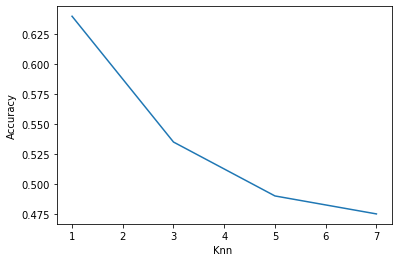

In [0]:
  #lda
  lda_eig_vals, lda_eig_vecs = lda_classification(training,mean,bonus)
  sorted_lda_evecs = sort_eigen_lda(lda_eig_vals, lda_eig_vecs)
  reduced_lda_training, reduced_lda_test = lda_r_dimensions(training,test,sorted_lda_evecs)
  acc_array=knn_lda(reduced_lda_training,reduced_lda_test,y_training,y_test)
  print_lda(acc_array)

# **BONUS_PCA**

In [0]:
  trainingB, y_trainingB, testB, y_testB,bonus = split_data_bonus(D,y)
  meanB,eValues, eVectors = pca_classification(trainingB)
  sorted_evals, sorted_evecs = sort_eigen_pca(eValues, eVectors)
  r_array = pca_r_dimensions(sorted_evals)
  Ur = projection_matrix(r_array,sorted_evecs) 
  knn_pca(trainingB,Ur,testB,y_trainingB,y_testB)


  